# Setup

In [1]:
import gc
import random

import astropy.units as u
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sunpy.map
import sunpy.visualization.colormaps.color_tables as ct
from astropy.visualization import AsinhStretch, ImageNormalize
from IPython.display import clear_output, display
from matplotlib.patches import Rectangle
from sunpy.coordinates import frames
from tqdm import tqdm
import json
import random
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display, clear_output

from contextlib import contextmanager

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from Library.Processing import *
from Library.IO import *
from Library.Model import *
from Library.Metrics import *
from Library.Config import *
from Library.CH import *
from Library.Plot import *

/opt/homebrew/Caskroom/miniconda/base/envs/icme3.12-metal/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# CH Stats

In [ ]:
# import sys, subprocess

# subprocess.run(
#     [sys.executable, "-m", "Scripts.Make", "Stats", "A1", "D1", "P1"],
#     check=True,
# )


In [4]:
df_p = pd.read_parquet(paths["artifact_root"] + "Paths.parquet")

In [5]:
train_df = df_p["20170501":"20170801"]

In [6]:
df = pd.read_parquet("Outputs/Artifacts/risc1/Stats/A1D1P1_stats.parquet")

In [7]:
mpl.rcParams["lines.markersize"] = 2  # default is 6

# ---- 1. Prepare df with datetime ----
df.index.name = "key"

dt_index = pd.to_datetime(df.index.str[:13], format="%Y%m%d_%H%M", errors="coerce")
df = df[~dt_index.isna()].copy()
df["time"] = dt_index[~dt_index.isna()]
df = df.sort_values("time")

stats_df = df.filter(like="oval")
stats_df.index = df["time"]


In [8]:
stats_df.columns = stats_df.columns.str.replace("_oval", '', regex=False)


In [9]:
stats_df.rel_area = stats_df.rel_area.replace([np.inf, -np.inf], np.nan)
stats_df.index = pd.to_datetime(stats_df.index, format="%Y%m%d_%H%M")
stats_df = stats_df.resample("1w").median()
stats_df

/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_98406/1679178750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df.rel_area = stats_df.rel_area.replace([np.inf, -np.inf], np.nan)
/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_98406/1679178750.py:3: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  stats_df = stats_df.resample("1w").median()


,fourier_distance,zernike_distance,rel_area,iou,dice
time,,,,,
2010-05-16,0.098285,0.538398,0.341135,0.597539,0.747478
2010-05-23,0.000000,0.000000,0.000000,1.000000,1.000000
2010-05-30,0.282690,0.640861,0.953908,0.046092,0.086698
2010-06-06,0.118813,0.718736,0.509758,0.441812,0.612857
2010-06-13,0.045180,0.153846,0.018944,0.822771,0.892297
...,...,...,...,...,...
2024-03-17,1.000000,1.000000,1.000000,0.000000,0.000000
2024-03-24,0.285175,0.591869,0.961024,0.037577,0.072433
2024-03-31,0.143249,0.711272,0.674205,0.302427,0.464291


/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_98406/831330037.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


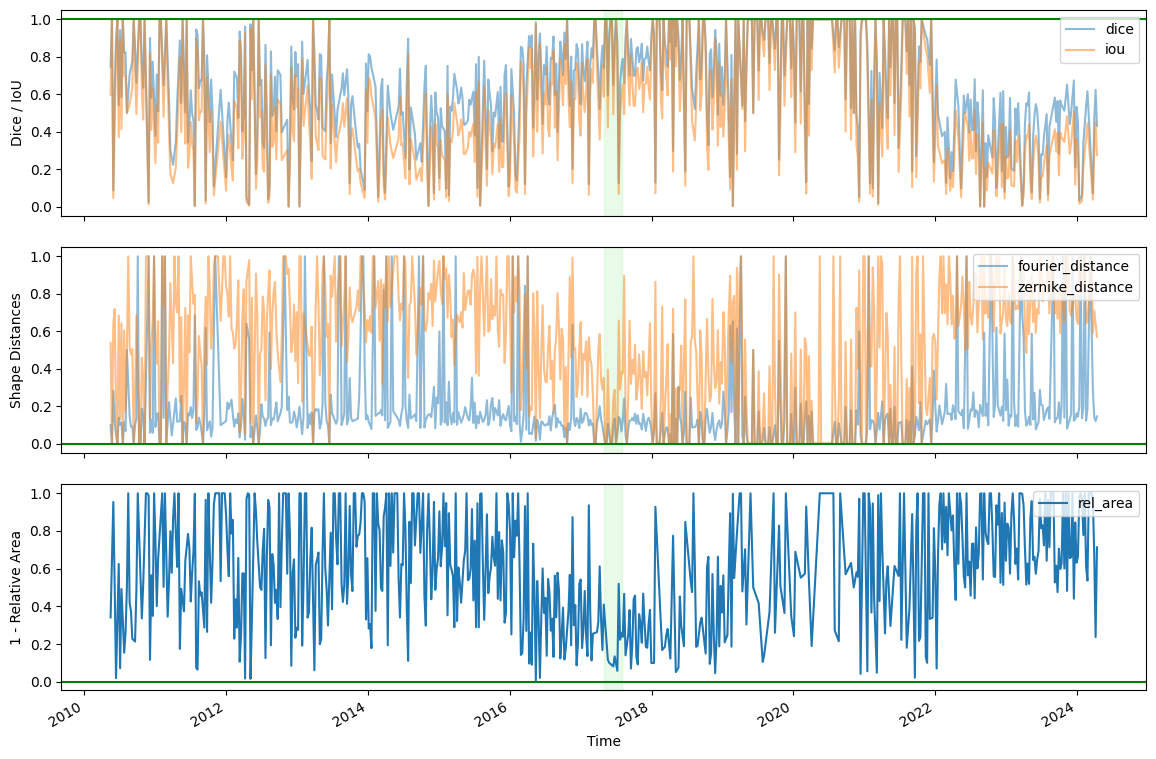

In [11]:
# ---- 3. Determine which rows are in training set ----
train_idx = set(train_df.index.astype(str))
is_train = df.index.astype(str).isin(train_idx)

# ---- 4. Make the plot with 3 axes ----
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(14, 10), sharex=True, gridspec_kw={"hspace": 0.15}
)

times = stats_df.index
# ====================================================
# AXIS 1 — Dice / IoU (remove zeros)
# ====================================================
if "dice" in stats_df:
    dice_clean = stats_df["dice"].replace([0], pd.NA).dropna()
    ax1.plot(dice_clean.index, dice_clean, label="dice", alpha=0.5)

if "iou" in stats_df:
    iou_clean = stats_df["iou"].replace([0], pd.NA).dropna()
    ax1.plot(iou_clean.index, iou_clean, label="iou", alpha=0.5)

ax1.axhline(1, color="green")
ax1.set_ylabel("Dice / IoU")
ax1.legend(loc="upper right")

# ====================================================
# AXIS 2 — Fourier / Zernike distances (remove ones)
# ====================================================
if "fourier_distance" in stats_df:
    fd_clean = stats_df["fourier_distance"].replace([1], pd.NA).dropna()
    ax2.plot(fd_clean.index, fd_clean, label="fourier_distance", alpha=0.5)

if "zernike_distance" in stats_df:
    zd_clean = stats_df["zernike_distance"].replace([1], pd.NA).dropna()
    ax2.plot(zd_clean.index, zd_clean, label="zernike_distance", alpha=0.5)

ax2.axhline(0, color="green")
ax2.set_ylabel("Shape Distances")
ax2.legend(loc="upper right")

# ====================================================
# AXIS 3 — rel_area (remove NaN and zeros)
# ====================================================
if "rel_area" in stats_df:
    rel = np.abs(stats_df["rel_area"].replace([0], pd.NA).dropna())
    ax3.plot(rel.index, rel, label="rel_area")
    ax3.axhline(0, color="green")

ax3.set_ylabel("1 - Relative Area")
ax3.set_xlabel("Time")
ax3.legend(loc="upper right")

# ====================================================
# 5. Shade training intervals
# ====================================================
axes = [ax1, ax2, ax3]
mask = is_train
t_array = df["time"].to_numpy()
n = len(mask)

for ax in axes:
    i = 0
    while i < n:
        if mask[i]:
            start = t_array[i]
            j = i
            while j + 1 < n and mask[j + 1]:
                j += 1
            end = t_array[j]
            ax.axvspan(start, end, color="lightgreen", alpha=0.2, zorder=-1)
            i = j + 1
        else:
            i += 1

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

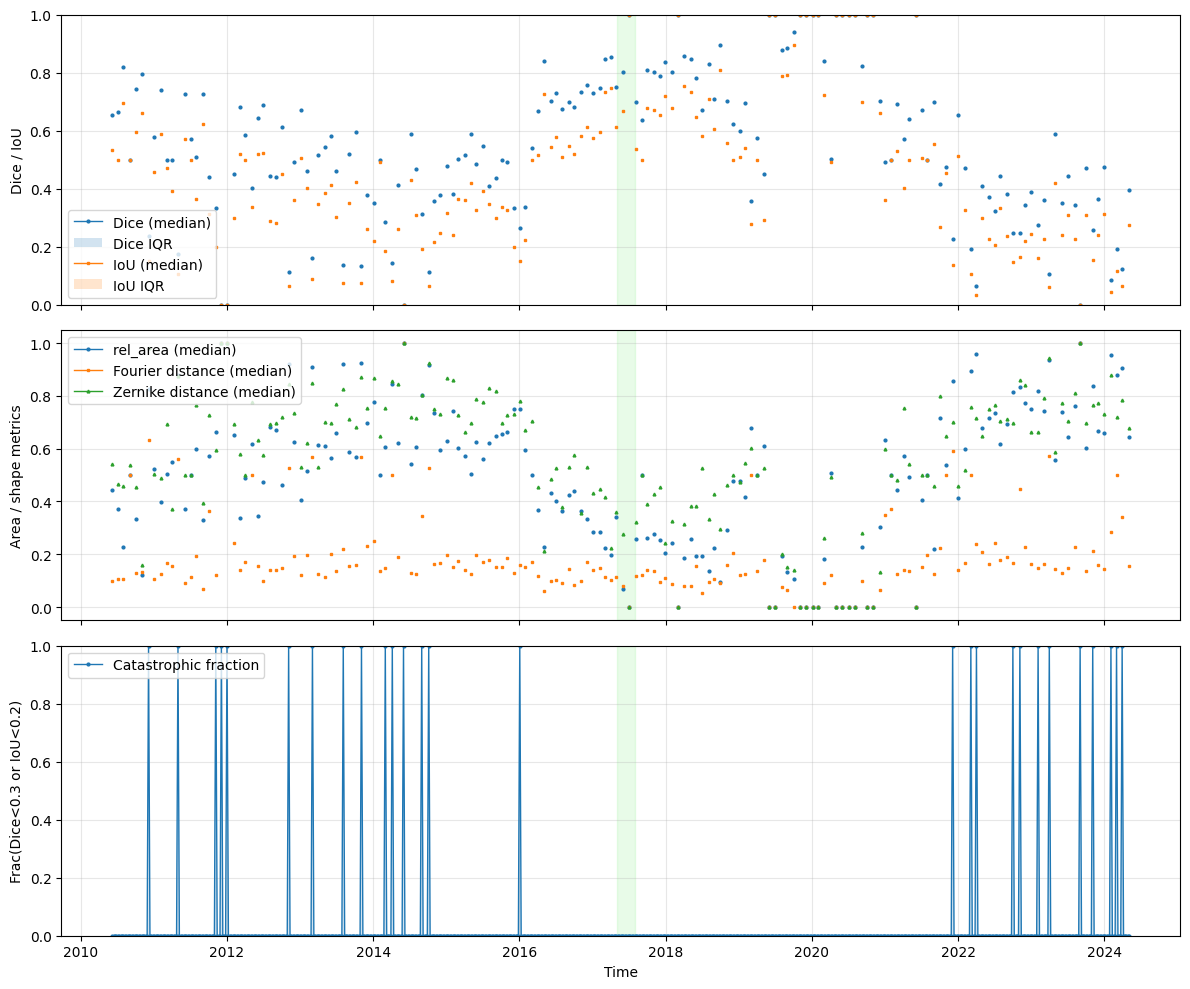

In [45]:
# stats_df:
# DatetimeIndex, daily
# columns: ["fourier_distance", "zernike_distance", "rel_area", "iou", "dice"]
# some NaNs


# 1) Add a "catastrophic failure" flag per day
#    Definition: dice < 0.3 OR iou < 0.2 (you can tweak these)
def add_catastrophic_flag(stats_df, dice_thr=0.3, iou_thr=0.2):
    df = stats_df.copy()
    # work only where metrics are defined
    mask_valid = df[["dice", "iou"]].notna().all(axis=1)
    df["catastrophic"] = False
    df.loc[mask_valid, "catastrophic"] = (df.loc[mask_valid, "dice"] < dice_thr) | (
        df.loc[mask_valid, "iou"] < iou_thr
    )
    return df


stats_df_ext = add_catastrophic_flag(stats_df)


# 2) Build monthly summary:
#    - median, 25th, 75th percentiles of all metrics
#    - catastrophic fraction per month
def build_monthly_summary(stats_df_ext):
    """
    stats_df_ext: daily stats with columns
      fourier_distance, zernike_distance, rel_area, iou, dice, catastrophic
    index: DatetimeIndex (daily)
    """

    # We'll ignore days where a metric is NaN for its aggregation
    # (resample + agg will do that by default)
    monthly = stats_df_ext.resample("7d").agg(
        {
            "dice": ["median", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
            "iou": ["median", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
            "rel_area": [
                "median",
                lambda x: x.quantile(0.25),
                lambda x: x.quantile(0.75),
            ],
            "fourier_distance": [
                "median",
                lambda x: x.quantile(0.25),
                lambda x: x.quantile(0.75),
            ],
            "zernike_distance": [
                "median",
                lambda x: x.quantile(0.25),
                lambda x: x.quantile(0.75),
            ],
            "catastrophic": "mean",  # fraction of catastrophic days in month
        }
    )

    # Clean up column names
    monthly.columns = [
        "dice_median",
        "dice_q25",
        "dice_q75",
        "iou_median",
        "iou_q25",
        "iou_q75",
        "rel_area_median",
        "rel_area_q25",
        "rel_area_q75",
        "fourier_median",
        "fourier_q25",
        "fourier_q75",
        "zernike_median",
        "zernike_q25",
        "zernike_q75",
        "catastrophic_fraction",
    ]

    return monthly


monthly_stats = build_monthly_summary(stats_df_ext)


# 3) Plot monthly medians + IQR + catastrophe rate
def plot_monthly_summary(monthly_stats):
    """
    monthly_stats: output of build_monthly_summary()
    index: month-end DateTimeIndex
    """

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    ax1, ax2, ax3 = axes

    # --- Panel 1: Dice & IoU (median + IQR) ---
    ax1.plot(
        monthly_stats.index,
        monthly_stats["dice_median"],
        label="Dice (median)",
        marker="o",
        linewidth=1,
    )
    ax1.fill_between(
        monthly_stats.index,
        monthly_stats["dice_q25"],
        monthly_stats["dice_q75"],
        alpha=0.2,
        label="Dice IQR",
    )

    ax1.plot(
        monthly_stats.index,
        monthly_stats["iou_median"],
        label="IoU (median)",
        marker="s",
        linewidth=1,
    )
    ax1.fill_between(
        monthly_stats.index,
        monthly_stats["iou_q25"],
        monthly_stats["iou_q75"],
        alpha=0.2,
        label="IoU IQR",
    )

    ax1.set_ylabel("Dice / IoU")
    ax1.set_ylim(0.0, 1.0)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="lower left")

    # --- Panel 2: rel_area + shape distances (medians only) ---
    # If rel_area is signed, median near 0 is good; you can also plot abs(rel_area)
    ax2.plot(
        monthly_stats.index,
        monthly_stats["rel_area_median"],
        label="rel_area (median)",
        marker="o",
        linewidth=1,
    )

    ax2.plot(
        monthly_stats.index,
        monthly_stats["fourier_median"],
        label="Fourier distance (median)",
        marker="s",
        linewidth=1,
    )
    ax2.plot(
        monthly_stats.index,
        monthly_stats["zernike_median"],
        label="Zernike distance (median)",
        marker="^",
        linewidth=1,
    )

    ax2.set_ylabel("Area / shape metrics")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="upper left")

    # --- Panel 3: fraction of catastrophic frames per month ---
    ax3.plot(
        monthly_stats.index,
        monthly_stats["catastrophic_fraction"],
        label="Catastrophic fraction",
        marker="o",
        linewidth=1,
    )
    ax3.fill_between(
        monthly_stats.index,
        0,
        monthly_stats["catastrophic_fraction"],
        alpha=0.2,
    )

    ax3.set_ylabel("Frac(Dice<0.3 or IoU<0.2)")
    ax3.set_xlabel("Time")
    ax3.set_ylim(0.0, 1.0)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc="upper left")

    axes = [ax1, ax2, ax3]
    mask = is_train
    t_array = df["time"].to_numpy()
    n = len(mask)

    for ax in axes:
        i = 0
        while i < n:
            if mask[i]:
                start = t_array[i]
                j = i
                while j + 1 < n and mask[j + 1]:
                    j += 1
                end = t_array[j]
                ax.axvspan(start, end, color="lightgreen", alpha=0.2, zorder=-1)
                i = j + 1
            else:
                i += 1

    plt.tight_layout()
    plt.show()


plot_monthly_summary(monthly_stats)

# Luminance Analysis

In [14]:
def init_stats():
    return {"n": 0, "mean": 0.0, "M2": 0.0, "min": np.inf, "max": -np.inf, "skipped": 0}


In [15]:
def update_stats(stats, arr):
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return
    stats["min"] = min(stats["min"], float(arr.min()))
    stats["max"] = max(stats["max"], float(arr.max()))

    n = stats["n"]
    mean = stats["mean"]
    M2 = stats["M2"]

    batch_n = arr.size
    batch_mean = float(arr.mean())
    batch_M2 = float(arr.var(ddof=0) * batch_n)

    if n == 0:
        stats["n"] = batch_n
        stats["mean"] = batch_mean
        stats["M2"] = batch_M2
        return

    delta = batch_mean - mean
    total_n = n + batch_n
    stats["mean"] = mean + delta * batch_n / total_n
    stats["M2"] = M2 + batch_M2 + (delta * delta) * n * batch_n / total_n
    stats["n"] = total_n


In [16]:
from collections import defaultdict
stats_by_year = defaultdict(init_stats)


In [17]:
for idx, row in tqdm(df.iterrows(), total=len(df)):
    year = str(idx)[:4]  # index like YYYYMMDD_HHMM
    try:
        _, img = prepare_fits(row.fits_path)
    except Exception:
        stats_by_year[year]["skipped"] += 1
        continue
    update_stats(stats_by_year[year], img)

100%|██████████| 10080/10080 [30:09<00:00,  5.57it/s]


In [ ]:
rows = []
for year, s in sorted(stats_by_year.items()):
    std = float(np.sqrt(s["M2"] / s["n"])) if s["n"] else float("nan")
    rows.append(
        {
            "year": year,
            "n": s["n"],
            "skipped": s["skipped"],
            "min": s["min"],
            "max": s["max"],
            "mean": s["mean"],
            "std": std,
        }
    )

yearly_stats = pd.DataFrame(rows)

    year          n  skipped  min  max      mean       std
0   2010  449839104        0  0.0  1.0  0.152637  0.180423
1   2011  773849088        0  0.0  1.0  0.142707  0.176348
2   2012  778043392        0  0.0  1.0  0.143616  0.175826
3   2013  781189120        0  0.0  1.0  0.145212  0.177652
4   2014  769654784        0  0.0  1.0  0.137194  0.176612
5   2015  787480576        0  0.0  1.0  0.139445  0.178525
6   2016  740294656        0  0.0  1.0  0.143376  0.178966
7   2017  775946240        0  0.0  1.0  0.151131  0.181351
8   2018  743440384        0  0.0  1.0  0.158684  0.184319
9   2019  761266176        0  0.0  1.0  0.158407  0.183920
10  2020  762314752        0  0.0  1.0  0.151199  0.181137
11  2021  746586112        0  0.0  1.0  0.147704  0.181287
12  2022  770703360        0  0.0  1.0  0.139893  0.176201
13  2023  729808896        0  0.0  1.0  0.148429  0.180785
14  2024  199229440        0  0.0  1.0  0.152987  0.181268


In [ ]:
rows.to_parquet("./Outputs/Stats/Luminance.parquet")
yearly_stats

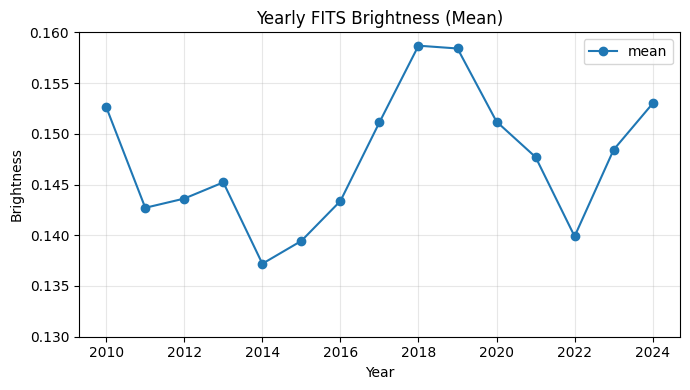

In [23]:
import matplotlib.pyplot as plt

# Ensure year is sorted and numeric-ish for plotting
plot_df = yearly_stats.copy()
plot_df["year"] = plot_df["year"].astype(int)
plot_df = plot_df.sort_values("year")

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(plot_df["year"], plot_df["mean"], marker="o", label="mean")

# ax.fill_between(
#     plot_df["year"],
#     plot_df["mean"] - plot_df["std"],
#     plot_df["mean"] + plot_df["std"],
#     alpha=0.2,
#     label="±1 std",
# )

ax.set_xlabel("Year")
ax.set_ylabel("Brightness")
ax.set_title("Yearly FITS Brightness (Mean)")
ax.grid(True, alpha=0.3)
ax.set_ylim(0.13, 0.16)
ax.legend()
plt.tight_layout()
plt.show()
